In [ ]:
import requests
import json
import sys
import overpy
import shapely.geometry as geometry
from shapely.ops import linemerge, unary_union, polygonize
import geopandas as gpd

In [2]:
import utils

In [3]:
overpass_url = "http://overpass-api.de/api/interpreter"

In [21]:
region = 'Boston'
extent = 'core'
county_ids = utils.county_ids.get_county_ids(region, extent)
xmin, xmax, ymin, ymax = utils.geometry.osm_bounds(region, county_ids, extent, file = False, raw = True)

In [22]:
bbox = (ymin, xmin, ymax, xmax)

(42.177926, -71.24115499999999, 42.470221800051995, -70.924897)

In [65]:
api = overpy.Overpass()

query = """ 
[out:json];
(

  way["leisure"="park"]{0};
  way["leisure"="nature_reserve"]{0};
  way["leisure"="playground"]{0};
  way["leisure"="garden"]{0};
  way["landuse"="grass"]{0};
  way["leisure"="pitch"]{0};
  way["leisure"="dogpark"]{0};
  way["leisure"="common"]{0};
  way["natural"="wood"]{0};
  way["natural"="beach"]{0};
  way["natural"="scrub"]{0};
  way["natural"="fell"]{0};
  way["natural"="heath"]{0};
  way["natural"="moor"]{0};
  way["natural"="grassland"]{0};
  way["landuse"="recreation_ground"]{0};
  way["landuse"="allotments"]{0};
  way["landuse"="cemetery"]{0};
  way["landuse"="meadow"]{0};
  way["landuse"="orchard"]{0};
  way["landuse"="greenfield"]{0};
  way["landuse"="vineyard"]{0};
  way["landuse"="village_green"]{0};
  way["landuse"="forest"]{0};
  
  relation["leisure"="park"]{0};
  relation["leisure"="nature_reserve"]{0};
  relation["leisure"="playground"]{0};
  relation["leisure"="garden"]{0};
  relation["landuse"="grass"]{0};
  relation["leisure"="pitch"]{0};
  relation["leisure"="dogpark"]{0};
  relation["leisure"="common"]{0};
  relation["natural"="wood"]{0};
  relation["natural"="beach"]{0};
  relation["natural"="scrub"]{0};
  relation["natural"="fell"]{0};
  relation["natural"="heath"]{0};
  relation["natural"="moor"]{0};
  relation["natural"="grassland"]{0};
  relation["landuse"="recreation_ground"]{0};
  relation["landuse"="allotments"]{0};
  relation["landuse"="cemetery"]{0};
  relation["landuse"="meadow"]{0};
  relation["landuse"="orchard"]{0};
  relation["landuse"="greenfield"]{0};
  relation["landuse"="vineyard"]{0};
  relation["landuse"="village_green"]{0};
  relation["landuse"="forest"]{0};
  );
(._;>;);
out;
""".format(bbox)
response = api.query(query)

In [66]:
line = []

for way in response.ways:
    coords = []
    for node in way.nodes:
        coords.append((node.lon, node.lat))
        
    line.append(geometry.LineString(coords))

merged = linemerge([*line]) 
borders = unary_union(merged) 
polygons = list(polygonize(borders))

In [67]:
gpd.GeoSeries(polygons).to_file('parks.geojson', driver='GeoJSON')

In [68]:
parks = gpd.GeoDataFrame(geometry=gpd.GeoSeries(polygons))

In [69]:
bgpoly = gpd.read_file('../spatial/Boston_all_block_group_poly.geojson')

In [70]:
parks_block =  gpd.overlay(parks, bgpoly, how='intersection')

/Users/Rick/opt/anaconda3/lib/python3.7/site-packages/geopandas/base.py:48: UserWarning: GeoSeries crs mismatch: None and epsg:4269
  warn("GeoSeries crs mismatch: {0} and {1}".format(this.crs, other.crs))


In [71]:
parks_block.to_file('parks_block.geojson', driver='GeoJSON')

In [72]:
parks_block.crs = {'init' :'epsg:4326'}
parks_block['area'] = parks_block.area*10000 # conversion to square kilometers
parks_block = parks_block.groupby(['GEOID']).sum()[['area']]

/Users/Rick/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [73]:
parks_block.to_csv('parks_block.csv', index = True)

In [74]:
parks_block

,area
GEOID,
250092011001,0.445017
250092011002,0.000784
250092011003,0.031685
250092011004,0.197100
250092022004,0.061783
...,...
250259815011,0.864138
250259815021,0.000185
250259816001,0.631715


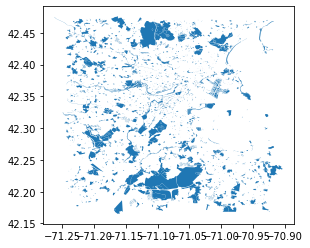

In [75]:
parks.plot()